**IMPORTING THE DATASET.**

Dog dataset


We will mount the dataset from google drive 




In [0]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from glob import glob

# load filenames for the dog images
dog_files = np.array(glob("/content/drive/My Drive/DogClassification-Dataset/dogImages2/*/*/*/*"))

np.random.shuffle(dog_files)

# print number of images in the dataset
print('There are %d total dog images.' % len(dog_files))

There are 8356 total dog images.


In [0]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import DataLoader
from glob import glob
import matplotlib.pyplot as plt                        
%matplotlib inline 
from PIL import Image
import torchvision.transforms as transforms

**Specify Data Loaders for the Dog Dataset**

In [5]:
breed_names = np.array(glob("/content/drive/My Drive/DogClassification-Dataset/dogImages2/dogImages/train/*"))

classes = breed_names

print('number of dogs breed is: {}'.format(len(breed_names)))

number of dogs breed is: 133


# **Pre-processing the dataset**

In [0]:
#specify the dataset path for each partition
train_path= '/content/drive/My Drive/DogClassification-Dataset/dogImages2/dogImages/train'
validate_path = '/content/drive/My Drive/DogClassification-Dataset/dogImages2/dogImages/valid'
test_path = '/content/drive/My Drive/DogClassification-Dataset/dogImages2/dogImages/test'

In [0]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

In [0]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

In [0]:
#prepare the dataset before we add it to the dataloader
train_data = datasets.ImageFolder(train_path, transform= data_transforms['train'])
validate_data = datasets.ImageFolder(validate_path, transform= data_transforms['valid'])
test_data = datasets.ImageFolder(validate_path, transform= data_transforms['test'])

In [0]:
data_loaders = {}

data_loaders['train'] = DataLoader(dataset = train_data,
                          batch_size = 20,
                          shuffle = True,
                          num_workers = 2)
data_loaders['validate'] = DataLoader(dataset= validate_data,
                             batch_size= 20,
                             shuffle= True,
                             num_workers= 2)
data_loaders['test'] = DataLoader(dataset= test_data,
                             batch_size= 20,
                             shuffle= True,
                             num_workers= 2)


In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Model Architecture**

we will use transfer learning and implement the resnet50 model to create a CNN to classify dog breed

In [0]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [13]:
model_ = models.resnet50(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
for param in model_.parameters():
    param.requires_grad = False
    
#adding the fully connected layer at the end of the model to classify the dog breed  
model_.fc = nn.Linear(2048, len(classes), bias=True)

fc_parameters = model_.fc.parameters()

In [0]:
for param in fc_parameters:
    param.requires_grad = True

In [0]:
#Model architecture
model_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer_transfer = optim.SGD(model_.parameters(), lr=0.001)

In [0]:
# cuda will help us work on the gpu
model_ = model_.cuda()

We will add a checkpoints, so we can continue the training if it did stop

In [18]:
from keras.callbacks import *
# the file that you want to save the progress you have reached 
filepath = "/content/drive/My Drive/DogClassification-Dataset/saved-models/model_transfer/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Using TensorFlow backend.


In [0]:
def train(n_epochs, data_loaders, model, optimizer_transfer, criterion_transfer, train_on_gpu, save_path, callbacks = callbacks_list):
  valid_loss_min = np.Inf

  for epoch in range(1, n_epochs+1):

    #keep traking of the training loss
    train_loss = 0.0
    valid_loss = 0.0

    ####################
    #train the model
    ####################
    model.train()
    # model by default is set to train 
    for batch_i, (data, target) in enumerate(data_loaders['train']):
      if train_on_gpu:
        data = data.cuda()
        target = target.cuda()
      # clear the gradients of all optimized variables
      optimizer_transfer.zero_grad()

      # forward pass: compute predicted outputs by passing inputs to the mode
      output = model(data)

      # calculate the batch loss 
      loss = criterion_transfer(output, target)

      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # perform a single optimization step (parameter update)
      optimizer_transfer.step()

      # update training loss 
      train_loss += loss.item()


      # print training loss every specified number of mini-batches
      if batch_i % 20 == 19:
        print('Epoch: %d, Batch: %d, Loss: %.16f' %(epoch, batch_i +1, train_loss / 20))
        train_loss = 0.0 

      ######################    
      # validate the model #
      ######################
      model.eval()
      for batch_idx, (data, target) in enumerate(data_loaders['validate']):
          # move to GPU
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
            
          output = model(data)
          loss = criterion_transfer(output, target)
          valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
      # print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, 
          train_loss,
          valid_loss
          ))
        
        
      if valid_loss < valid_loss_min:
          torch.save(model.state_dict(), save_path)
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          valid_loss_min = valid_loss
            
  # return trained model
  return model

In [0]:
trained_model = train(20, data_loaders, model_, optimizer_transfer, criterion_transfer, train_on_gpu, '/content/drive/My Drive/DogClassification-Dataset/saved-models/model_transfer.pt')

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [23]:
# loading the model from the file
trained_model.load_state_dict(torch.load('/content/drive/My Drive/DogClassification-Dataset/saved-models/model_transfer.pt'))

<All keys matched successfully>

In [24]:
test(data_loaders, trained_model, criterion_transfer, train_on_gpu)

Test Loss: 1.621767


Test Accuracy: 75% (636/840)


In [0]:
def load_image(img_path):    
    transformed_image = Image.open(img_path).convert('RGB')
    # resize to (224, 224)
    in_transform = transforms.Compose([
                        transforms.Resize(size=(224, 224)),
                        transforms.ToTensor()]) # normalizaiton parameters from pytorch doc.

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    transformed_image = in_transform(transformed_image)[:3,:,:].unsqueeze(0)
    return transformed_image

In [0]:
class_names = [item[4:].replace("_", " ") for item in data_loaders['train'].dataset.classes]

In [0]:
def predict_breed(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [0]:

def predicted_images(prediction):
  '''
  this method will print 4 images for the predicted dog breed

  Parameters: the predicted dog breed

  '''
  prediction_ = prediction.replace(' ', '_')
  breed_names = glob('/content/drive/My Drive/DogClassification-Dataset/dogImages2/dogImages/train/*')
  found_it = False

  for breed in breed_names:
    if prediction_ in breed:
      found_it = True

      full_path = os.path.join(breed, '*')
      dog_images = glob(full_path)
  
  
  if found_it:
    for i, imge in enumerate(dog_images):
      if i == 4:
        break
      dog = Image.open(imge)
      plt.imshow(dog)
      plt.show()
  else:
    print('somthing went wrong!')

In [0]:
def run_app(img_file):
  img = Image.open(img_file)
  plt.imshow(img)
  plt.show()

  predition = predict_breed(trained_model, class_names, img_file)
  print('Mmmm.. I think you look like... {}'.format(predition))
  predicted_images(predition)

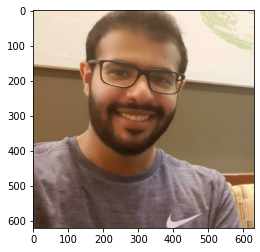

Mmmm.. I think you look like... Maltese


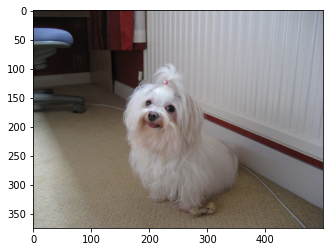

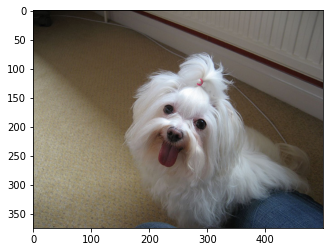

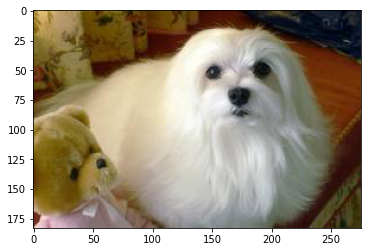

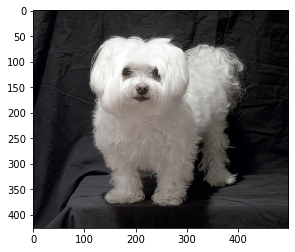

In [51]:
run_app('/content/drive/My Drive/DogClassification-Dataset/humans/a9263a44-5550-40b9-a420-16008c81a264.jpg')